In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from matplotlib.pyplot import imread
from skimage.transform import resize
from PIL import Image

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!nvidia-smi

Tue Apr 26 07:15:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      Off  | 00000000:04:00.0 Off |                    0 |
| N/A   55C    P0    61W / 250W |  11544MiB / 22945MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      Off  | 00000000:82:00.0 Off |                    0 |
| N/A   

In [4]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = resize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    img = torch.cat([img[0:3]])
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    print(type(img))
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds].long()]
        c = c[prev_word_inds[incomplete_inds].long()]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds].long()]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas

In [5]:
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(int(np.ceil(len(words) / 5.)), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()
    return words

In [6]:
import warnings
warnings.filterwarnings("ignore")

def main(image_path):
    
    model_path = "BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar"
    wordmap_path = "dataset/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json"
    beam_size = 5

    # Load model
    checkpoint = torch.load(model_path, map_location=str(device))
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()

    # Load word map (word2ix)
    with open(wordmap_path, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size)
    alphas = torch.FloatTensor(alphas)

    # Visualize caption and attention of best sequence
    words = visualize_att(image_path, seq, alphas, rev_word_map, False)
    
    text = ""
    for i in words:
        if(i!="<start>" and i!="<end>" and i!="<unk>"):
            text = text + i + " "
    
    return text

## Get the caption and audio signal of the image

<class 'torch.Tensor'>


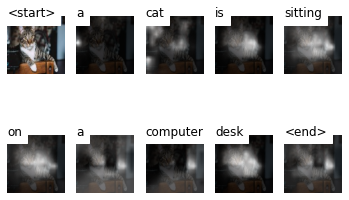

Caption of the given image : a cat is sitting on a computer desk 


In [14]:
from gtts import gTTS
from playsound import playsound
import os

image_path = "samples/sample4.jpg"
text = main(image_path)
print("Caption of the given image :",text)
audio = gTTS(text=text, lang='en', slow=False)
audio.save("output.mp3")
#playsound("output.mp3")